# SVD Calculation

This example will load data from a Kinetica to a sparse matrix compute its [SVD][SVD] composition using [PyTorch][PYTORCH].

[SVD]: <https://en.wikipedia.org/wiki/Singular-value_decomposition>
[PYTORCH]: <https://pytorch.org/docs/stable/torch.html>

### Steps

1. Load `amazon_matrix` table into a DataFrame. 
1. Use pandas crosstab() to create a sparse matrix.
1. Compute the SVD composition of the sparse matrix.
1. Multiply the $\boldsymbol{\Sigma}$ values into the $\mathbf{U}$ and $\mathbf{V}$ matrices.
1. Truncate $\mathbf{U}$ and $\mathbf{V}$ matrices to 10 principal components.
1. Save $\tilde{\mathbf{U}}$ vectors to `svd_cust_vec` and $\tilde{\mathbf{V}}$ to `svd_item_vec`
1. Analyze approximated results for errors.

### Prerequisites

You should have run the [svd_1_ingest.ipynb](svd_1_ingest.ipynb) notebook to ingest the dataset too kinetica tables. 

### Caveats

This example is for demonstration purposes only and may need additional considerations if applied in practice:

* It does not use a sparse datatype to represent the sparse matrix and will have issues scaling to thousands of products.
* More advanced algorithms like [SVD++][SVDPP] exist that take into account unknowns contributed by un-rated products.

[SVDPP]: <http://www.cs.rochester.edu/twiki/pub/Main/HarpSeminar/Factorization_Meets_the_Neighborhood-_a_Multifaceted_Collaborative_Filtering_Model.pdf>

In [15]:
# iPython settings
%reload_ext autoreload
%autoreload 1
%matplotlib inline

import sys 
sys.path.append('../KJIO')
import numpy as np
import pandas as pd
%aimport kapi_io
%aimport kodbc_io

# assign GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# create tables in this schema
SCHEMA = 'SVD'

### Get rowcount of matrix table

In [16]:

MATRIX_TABLE = 'amazon_matrix'
_rows = kodbc_io.get_row('select count(1) as rowcount from {}'.format(MATRIX_TABLE))
print('Table {} has {} rows'.format(MATRIX_TABLE, _rows.rowcount))

Connected to GPUdb ODBC Server (6.2.0.17.20180825221415)
Table amazon_matrix has 115494 rows


### Load ratings table into DataFrame

In [17]:
# load input table
_table_df = kapi_io.load_df(MATRIX_TABLE)
_table_df['star_rating'] = _table_df['star_rating'].astype(np.int32)
display(_table_df.head())

Getting 115494 records from <amazon_matrix>............
Records Retrieved: (115494, 3)


,customer_id,product_parent,star_rating
0,14675,601818824,5
1,14675,693643452,5
2,14675,37626525,5
3,15890,928869196,5
4,20045,936886135,5


### Construct rating matrix

This will produce a rating matrix with dimensions of $customers \times products$. This matrix is sparse because most values are zero.

In [35]:
# Construct sparse matrix
_matrix_df = pd.crosstab(
    _table_df.customer_id,
    _table_df.product_parent,
    _table_df.star_rating,
    aggfunc=np.sum,
    normalize=False).fillna(0)

display('Shape: ' + str(_matrix_df.shape))

_matrix_df.head()

'Shape: (65531, 497)'

product_parent,9574613,10058938,16422355,23959419,27598889,30052336,37626525,41424964,45695216,47882917,...,974945078,975919902,977333517,980240215,983956350,991917217,992941133,993251099,993515273,996048589
customer_id,,,,,,,,,,,,,,,,,,,,,
11152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14675,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Generate SVD Results

In this example we factor a sparse matrix $\mathbf{A}$ of dimensions $customers \times items$ into 3 separate components of the form 

$\mathbf{A} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^*$

* $\mathbf{A}$ Input matrix has dimensions $customers \times products$ $(C \times P)$.
* $\mathbf{U}$ Contains left singular vectors with dimensions $customers \times rank$ $(C \times R)$. These are column vectors containing principal components of the customers.
* $\mathbf{V}$ Contains the right singular vector with dimensions $rank \times products$ $(R \times P)$. These are row vectors containing principle components of the products.
* $\boldsymbol{\Sigma}$ Diagonal matrix containing singular values with dimensions $(R \times R)$. These are magnitudes of the singular vectors.

In [19]:
# convert to numpy
_matrix_np = _matrix_df.values.astype(np.float64)

import torch as th
print('Calculating SVD...')
#_matrix_cuda = th.tensor(_matrix_np).cuda()
_matrix_cuda = th.tensor(_matrix_np)
_svd_u, _svd_s, _svd_v = th.svd(_matrix_cuda)

print('SVD dimensions: U={} sig={} V={}'
    .format([*_svd_u.shape], [*_svd_s.shape], [*_svd_v.shape]))

Calculating SVD...
SVD dimensions: U=[65531, 497] sig=[497] V=[497, 497]


### Orthogonality

It should be noted that $\mathbf{U}$ and $\mathbf{V}$ matrices have columns have the following properties:

* The dot-product of any 2 columns is zero because the columns are orthogonal:

$\mathbf{u}_i \cdot \mathbf{u}_j = \left\Vert \mathbf{u}_i \right\Vert \left\Vert \mathbf{u}_j \right\Vert\cos(90) = 0$

* The Magnitude of any column is 1 because they are unit vectors:

$\mathbf{u}_i \cdot \mathbf{u}_i = \left\Vert \mathbf{u}_i \right\Vert \left\vert \mathbf{u}_i \right\Vert \cos(0) = \left\Vert \mathbf{u}_i \right\Vert ^2 = 1$

This is demonstrated below.

In [20]:
u0 = _svd_u[:, 0]
u1 = _svd_u[:, 1]

dot = th.dot(u0,u0)
print('Dot product of u0,u0 is: {:f}'.format(dot.item()))

dot = th.dot(u0,u1)
print('Dot product of u0,u1 is: {:f}'.format(dot.item()))

Dot product of u0,u0 is: 1.000000
Dot product of u0,u1 is: 0.000000


### Truncate U and V to create the approximation

We can truncate trailing singular vectors to get a reduced rank approximation 

$\tilde{\mathbf{A}} = \mathbf{U} \tilde{\boldsymbol{\Sigma}} \mathbf{V}^T$ 

where $\tilde{\boldsymbol{\Sigma}}$ has truncated diagonal values and $\tilde{\mathbf{A}}$ is an approximation of the original sparse matrix.

In [21]:
TRUNCATE_VECTORS = 10
_dim = min(TRUNCATE_VECTORS, _svd_u.shape[1])
_svd_u_approx = _svd_u[: , :_dim]
_svd_s_approx = _svd_s[:_dim]
_svd_v_approx = _svd_v[: , :_dim]

print('SVD approximated: U={} sig={} V={}'
    .format([*_svd_u_approx.shape], [*_svd_s_approx.shape], [*_svd_v_approx.shape]))

SVD approximated: U=[65531, 10] sig=[10] V=[497, 10]


### Multiply singular values into U and V matrices

We can multiply the singular values from $ \boldsymbol{\Sigma}$ into $\mathbf{U}$ and $\mathbf{V}$. This gives matrices with magnitueds that can be used for clustering.

$\mathbf{A} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T 
= (\mathbf{U}\sqrt{\boldsymbol{\Sigma}})(\mathbf{V} \sqrt{\boldsymbol{\Sigma}})^T$

We create separate tables with the magnitudes:

$\mathbf{\tilde{u}}_c^T = [ U \sqrt{\boldsymbol{\Sigma}} ]_c$

$\mathbf{\tilde{v}}_p^T = [ V \sqrt{\boldsymbol{\Sigma}} ]_p$

In [22]:
# multiuply U and V by sqrt(S)
_svd_s_eigen = th.sqrt(_svd_s_approx).diag()
_svd_u_eigen = _svd_u_approx.matmul(_svd_s_eigen)
_svd_v_eigen = _svd_v_approx.matmul(_svd_s_eigen)

print('SVD eigen: U={} V={}'
    .format([*_svd_u_eigen.shape], [*_svd_v_eigen.shape]))

SVD eigen: U=[65531, 10] V=[497, 10]


### Save customer vectors to Kinetica

We save the truncated $\tilde{\mathbf{U}}$ matrix to table `svd_cust_vec`. Each row has a vector of dimension 10 with information about the customer's rating behavior.

In [23]:
%aimport kapi_io

# create column names for the vector
_col_names = ['U' + str(i) for i in range(_svd_u_eigen.shape[1])]

# reset the index so that it does not get converted to a shard key
_u_vec = pd.DataFrame(_svd_u_eigen.cpu().numpy(), 
                        columns=_col_names,
                        index=_matrix_df.index).reset_index()

kapi_io.save_df(_u_vec, 'svd_cust_vec', SCHEMA, _is_replicated=True)
_u_vec.head()

Dropping table: <svd_cust_vec>
Creating replicated  table: <svd_cust_vec>
Column 0: <customer_id> (long) []
Column 1: <U0> (double) []
Column 2: <U1> (double) []
Column 3: <U2> (double) []
Column 4: <U3> (double) []
Column 5: <U4> (double) []
Column 6: <U5> (double) []
Column 7: <U6> (double) []
Column 8: <U7> (double) []
Column 9: <U8> (double) []
Column 10: <U9> (double) []
Inserted rows into <SVD.svd_cust_vec>: 65531


,customer_id,U0,U1,U2,U3,U4,U5,U6,U7,U8,U9
0,11152,-0.000987,-0.005919,-0.016551,0.002591,-0.006140,-0.017519,-0.005205,0.015159,0.016626,-0.196109
1,12976,-0.000404,-0.001781,-0.004311,-0.000810,-0.000784,-0.005010,-0.001469,0.002630,0.004393,-0.025996
2,14254,-0.000113,-0.000180,-0.001239,-0.002130,-0.000394,-0.000141,-0.000391,0.000155,0.001258,-0.000676
3,14675,-0.002395,-0.019058,-0.062350,0.034907,-0.029845,-0.000411,0.002203,0.004710,0.003852,-0.067047
4,15657,-0.001306,-0.002113,-0.004605,-0.001511,-0.001459,-0.002829,-0.002562,0.003995,0.001969,-0.016334


### Save product vectors to Kientica

We save the truncated $\tilde{\mathbf{V}}^T$ matrix to table `svd_item_vec`. Each row is a vector of dimension 10 containing a compressed representation of the product ratings.

In [24]:
# create column names for the vector
_col_names = ['V' + str(i) for i in range(_svd_u_eigen.shape[1])]

_v_vec = pd.DataFrame(_svd_v_eigen.cpu().numpy(),
                        columns=_col_names,
                        index=_matrix_df.columns.astype(np.str, copy=True))
kapi_io.save_df(_v_vec, 'svd_item_vec', SCHEMA)
_v_vec.head()

Dropping table: <svd_item_vec>
Creating  table: <svd_item_vec>
Column 0: <product_parent> (string) ['char16', 'shard_key']
Column 1: <V0> (double) []
Column 2: <V1> (double) []
Column 3: <V2> (double) []
Column 4: <V3> (double) []
Column 5: <V4> (double) []
Column 6: <V5> (double) []
Column 7: <V6> (double) []
Column 8: <V7> (double) []
Column 9: <V8> (double) []
Column 10: <V9> (double) []
Inserted rows into <SVD.svd_item_vec>: 497


,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9
product_parent,,,,,,,,,,
9574613,-0.020669,-0.035234,-0.037702,0.011102,-0.022955,-0.008894,-0.023857,-0.014683,0.001188,-0.036309
10058938,-0.024712,-0.237303,-0.048841,0.012727,-0.010097,-0.026615,-0.044964,-0.018914,0.004009,-0.088032
16422355,-0.011249,-0.089608,-0.047144,0.010263,0.006285,0.000460,0.008407,-0.003717,0.002207,-0.027726
23959419,-0.002988,-0.044881,-0.169532,-0.172110,-0.056766,-0.092268,0.003090,0.015442,0.139214,-0.104559
27598889,-0.014708,-0.020488,-0.057387,0.031323,-0.031120,-0.024888,-0.012385,0.004776,0.016489,-0.017681


## Result Analisys

### Plot singular values

The $\Sigma$ matrix contains the singular values that give the magnitudes of the singular vectors. We can calculate how much we lose through truncation. This demonstrates that most of the magnitudes are concentrated in the leading vectors.

If we retain R principal components then the area under a segment of the curve ending with R indicates how much of the total contribution those components make. This can be calculated by considering the ratio of the magnitude of the components we are retaining to the sum of all components.

$\displaystyle \epsilon(r) = \frac{\sigma_{reduced}}{\sigma_{total}} = \frac{\sum^{R}_{r} \sigma_r}{\sum_{r} \sigma_r}$

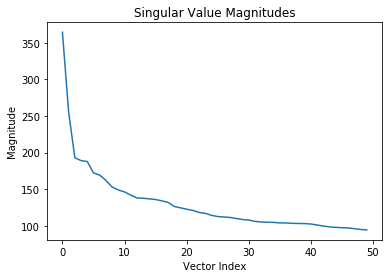

In [25]:
from matplotlib import pyplot as plt

_svd_s_np = _svd_s.cpu().numpy()
plt.title('Singular Value Magnitudes')
plt.xlabel('Vector Index')
plt.ylabel('Magnitude')
plt.plot(_svd_s_np[:50])

### Calculate approximated matrix

Here we Multiply calculate an aproximated rating matrix.

$\tilde{\mathbf{A}} = \tilde{\mathbf{U}}\tilde{\mathbf{V}}^T$

In [26]:
print('SVD approx: U={} s={} V={}'
    .format([*_svd_u_approx.shape], [*_svd_s_approx.shape], [*_svd_v_approx.shape]))

# calculate reduced rank matrix
_svd_s_diag = th.diag(_svd_s_approx)
_svd_v_t = _svd_v_approx.t()
_matrix_approx_cuda = _svd_u_approx.matmul(_svd_s_diag).matmul(_svd_v_t)

# copy result back from vRAM to RAM
_matrix_approx_np = _matrix_approx_cuda.cpu().numpy()
print('Matrix approx: {}'
    .format([*_matrix_approx_np.shape]))

# approximated dataframe
_approx_df = pd.DataFrame(_matrix_approx_np, 
                          columns=_matrix_df.columns, 
                          index=_matrix_df.index)
#_approx_df.head()

SVD approx: U=[65531, 10] s=[10] V=[497, 10]
Matrix approx: [65531, 497]


### Approximation error per customer

Here we calculate the magnitude of the error to determine how accurate the approximation is per customer.

$ \epsilon_c = \mathbf{a}_c − \mathbf{\tilde{a}}_c  = \mathbf{r}_c $

When producing a recommendation we can gauge the magnitude of the approximation error which is similar to the root-mean-square-deviation (RMSD). If this is too large it is an indication that the prediction is not accurate because the customer is an outlier.

$\displaystyle \operatorname{RMSD}(\mathbf{r}_c) = \sqrt{ \frac{\sum_i^R r_i^2 }{R} } = \sqrt{ \frac{\mathbf{r}_c \cdot \mathbf{r}_c}{R} } = \frac{\Vert \mathbf{r}_c \Vert }{\sqrt{R}} $

In [27]:
print('Input matrices: orig={} approx={}'
    .format([*_matrix_cuda.shape], [*_matrix_approx_cuda.shape]))

_diff = _matrix_cuda - _matrix_approx_cuda
_rmsd = _diff.pow(2).mean(dim=1).sqrt()
_rmsd_df = pd.DataFrame(_rmsd.cpu().numpy(), 
                        columns=['error'], 
                        index=_matrix_df.index)

_rmsd_df.sort_values('customer_id', ascending=True).head(10)

Input matrices: orig=[65531, 497] approx=[65531, 497]


,error
customer_id,
11152,0.297751
12976,0.316818
14254,0.224274
14675,0.383462
15657,0.388331
15890,0.216886
18275,0.261497
19434,0.224272
20045,0.317109


### Compare original with reduced rank matrix

Here we visualize the approximated and actual matrices where x-axis varies with product and y-axis varies with customer.

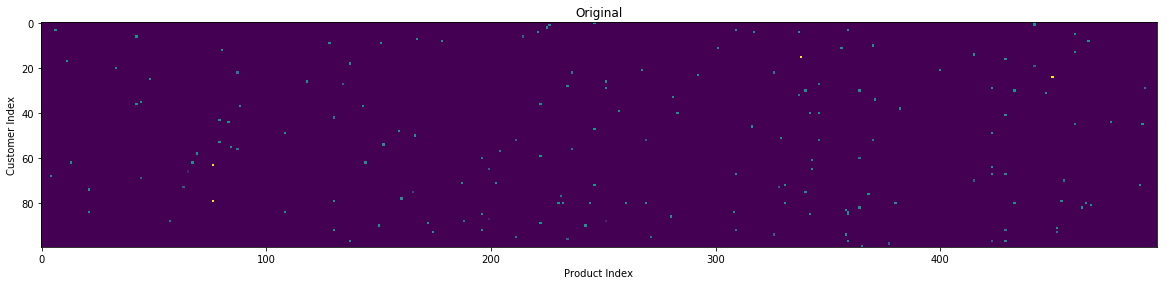

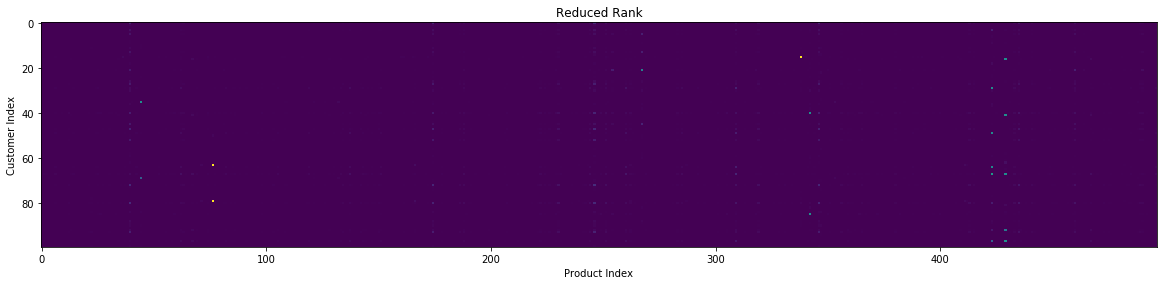

In [28]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20,150))
plt.imshow(_matrix_np[:100,:500])
plt.xlabel('Product Index')
plt.ylabel('Customer Index')
plt.title('Original')
plt.show()

# remove values < 0
_matrix_approx_fix = np.copy(_matrix_approx_np)
_matrix_approx_fix[_matrix_approx_fix < 0] = 0

plt.figure(figsize=(20,150))
plt.imshow(_matrix_approx_fix[:100,:500])
plt.xlabel('Product Index')
plt.ylabel('Customer Index')
plt.title('Reduced Rank')
plt.show()